<a href="https://colab.research.google.com/github/All4Nothing/pytorch-DL-project/blob/main/Ch05_RandWireeNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05. 하이브리드 고급 모델

## RandWireNN  
RandWireNN(Randomly Wired Neural Network, 무작위로 연결된 신경망)  
모델 아키텍처가 어떻게 생겼는지 결정하지 않고 대신 주어진 작업을 위한 최적의 아키텍처를 발견하는 네트워크 생성기를 실행하는 모델 유형으로, 이 결과로 얻게 되는 네트워크를 RandWireNN이라 한다.

### RandWireNN 모델의 이해  
먼저 랜덤 그래프 생성 알고리즘은 사전에 정의된 노드 수를 가지고 랜덤 그래프를 생성하는 데 사용된다. 이 그래프가 다음과 같은 몇 가지 정의하에 신경망으로 변환된다.  
- **Directed**: 이 그래프는 방향성 그래프로 제한되며 이에 상응하는 신경망에서 edge의 방향은 데이터 흐름의 방향을 뜻한다.  
- **Aggregation**: 하나의 노드(또는 뉴런)로 들어오는 여러 edge의 weighted sum(가중합)을 구한다. 이때 가중치는 학습 가능하다.  
- **Transformation**: 이 그래프의 각 노드 내부에 표준 연산이 적용된다. ReLU, 3x3  분리 가능한(일반적인 3x3 합성곱 다음에 1x1 점별 합성곱이 뒤따르는) 합성곱, 정규화가 순서대로 적용된다. 이 연산을 ReLU-Conv-BN Triplet(삼중항)이라고도 한다.  
- **Distribution**: 마지막으로 각 뉴런에서 밖으로 나가는 여러 edge가 앞서 언급한 triplet 연산의 복사본을 전달한다.  

여기에 단일 입력 노드(source)와 단일 출력 노드(sink)를 이 그래프에 추가해 이 랜덤 그래프를 신경망으로 완전히 변환한다. 그래프가 신경망으로 구현되면, 다양한 머신러닝 작업을 위해 훈련될 수 있다.  
ReLU-Conv-BN Triplet 유닛에서 채널/특징의 출력 개수는 반복 가능하도록 채널/특징의 입력 개수와 동일하다. 그렇지만 당면한 작업 유형에 따라 다운스트림 채널 개수가 증가하고 데이터/이미지의 공간 크기가 감소함에 따라 이 그래프 중 여러 개를 준비할 수 있다. 마지막으로 이렇게 준비된 그래프는 하나의 sink를 다른 하나의 source에 순차적으로 연결해 서로 연결할 수 있다.

## Develop RandWireNN with PyTorch

### Imports

In [1]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4130 sha256=0ce69634292ecea74cb1e6e6228adc97532607e462a7c7b64944ace2c706dedb
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from torchvision import datasets, transforms
from torchviz import make_dot

import os
import time
import random
import networkx as nx
import yaml
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### helper functions

In [3]:
def plot_results(list_of_epochs, list_of_train_losses, list_of_train_accuracies, list_of_val_accuracies):
    plt.figure(figsize=(20, 9))
    plt.subplot(1, 2, 1)
    plt.plot(list_of_epochs, list_of_train_losses, label='training loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(list_of_epochs, list_of_train_accuracies, label='training accuracy')
    plt.plot(list_of_epochs, list_of_val_accuracies, label='validation accuracy')
    plt.legend()
    if not os.path.isdir('./result_plots'):
        os.makedirs('./result_plots')
    plt.savefig('./result_plots/accuracy_plot_per_epoch.jpg')
    plt.close()

### training routine

In [4]:
def set_lr(optim, epoch_num, lrate):
    """adjusts lr to starting lr thereafter reduced by 10% at every 20 epochs"""
    lrate = lrate * (0.1 ** (epoch_num // 20))
    for params in optim.param_groups:
        params['lr'] = lrate

In [5]:
def train(model, train_dataloader, optim, loss_func, epoch_num, lrate):
    model.train()
    loop_iter = 0
    training_loss = 0
    training_accuracy = 0
    for training_data, training_label in train_dataloader:
        set_lr(optim, epoch_num, lrate)
        training_data, training_label =\
            training_data.to(device), training_label.to(device)
        optim.zero_grad()
        pred_raw = model(training_data)
        curr_loss = loss_func(pred_raw, training_label)
        curr_loss.backward()
        optim.step()
        training_loss += curr_loss.data
        pred = pred_raw.data.max(1)[1]

        curr_accuracy = (
            float(pred.eq(training_label.data).sum()) * 100. / len(training_data)
        )
        training_accuracy += curr_accuracy
        loop_iter += 1
        if loop_iter % 100 == 0:
            print(
                f"epoch {epoch_num}, loss: {curr_loss.data}, accuracy: {curr_accuracy}")

    data_size = len(train_dataloader.dataset) // batch_size
    return training_loss / data_size, training_accuracy / data_size

### accuracy metric

In [6]:
def accuracy(model, test_data_loader):
    model.eval()
    success = 0
    with torch.no_grad():
        for test_data, test_label in test_data_loader:
            test_data, test_label = test_data.to(device), test_label.to(device)
            pred_raw = model(test_data)
            pred = pred_raw.data.max(1)[1]
            success += pred.eq(test_label.data).sum()

    return float(success) * 100. / len(test_data_loader.dataset)

### data loader and load data

Datset `Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009`

In [7]:
batch_size = 64

In [8]:
def load_dataset(batch_size):
    transform_train_dataset = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
    ])

    transform_test_dataset = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4983, 0.4795, 0.4382), (0.2712, 0.2602, 0.2801)),
    ])
    train_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10('dataset', transform=transform_train_dataset,
                         train=True, download=True),
        batch_size=batch_size,
        shuffle=True
    )
    test_dataloader = torch.utils.data.DataLoader(
        datasets.CIFAR10('dataset', transform=transform_test_dataset,
                         train=False),
        batch_size=batch_size,
        shuffle=False
    )
    return train_dataloader, test_dataloader
train_dataloader, test_dataloader = load_dataset(batch_size)

100%|██████████| 170498071/170498071 [00:01<00:00, 99293902.29it/s] 


Extracting dataset/cifar-10-python.tar.gz to dataset


### graph class def

여기서는 유명한 랜덤 그래프 모델인 **Watts Strogatz(WS, 와츠-스트로가츠) 모델을 사용하겠다. 이는 RandWireNNs의 연구 논문에서 실험했던 세 개의 모델 중 하나다.  
이 모델에는 두 개의 parameter가 있다.  
- 각 노드의 이웃 개수(반드시 짝수여야 함), K  
- 재연결할 확률, P  

먼저 그래프의 전체 N개 노드는 원의 형태로 배열되고 각 노드는 왼쪽으로 K/2개의 노드에 연결되고 오른쪽으로 K/2개의 노드에 연결된다. 그런 다음 각 노드를 시계 방향으로 K/2번 돌아다닌다. m번째 돌 때마다(0<m<K/2) 현재 노드와 오른쪽 m번째에 위치한 이웃이 P의 확률로 재연결된다.  
여기에서 재연결이란 edge가 현재 노드와 현재 노드의 m번째 이웃과는 다른 노드와 현재 노드를 잇는 다른 edge로 교체되는 것을 뜻한다. `RndGraph` 클래스의 `make_graph_obj` 메서드는 `networks`라이브러리를 사용해 WS 그래프 모델을 인스턴스화 한다.  
또한, 그래프의 노드와 edge 목록을 반환하는 `get_graph_config` 메서드를 추가한다. 이 메서드는 추상적인 그래프를 신경망으로 변환할 때 도움이 된다.
또, 재현 가능성과 효율성을 위해 생성된 그래프를 캐시에 저장하고 로딩하는 `get_graph_config`와 `save_graph` 메서드를 정의한다.

In [9]:
class RndGraph(object):
    def __init__(self, num_nodes, graph_probability, nearest_neighbour_k=4,
                 num_edges_attach=5):
        self.num_nodes = num_nodes
        self.graph_probability = graph_probability
        self.nearest_neighbour_k = nearest_neighbour_k
        self.num_edges_attach = num_edges_attach

    def make_graph_obj(self):
        graph_obj = nx.random_graphs.connected_watts_strogatz_graph(
            self.num_nodes, self.nearest_neighbour_k, self.graph_probability)
        return graph_obj

    def get_graph_config(self, graph_obj):
        incoming_edges = {}
        incoming_edges[0] = []
        node_list = [0]
        last = []
        for n in graph_obj.nodes():
            neighbor_list = list(graph_obj.neighbors(n))
            neighbor_list.sort()

            edge_list = []
            passed_list = []
            for nbr in neighbor_list:
                if n > nbr:
                    edge_list.append(nbr + 1)
                    passed_list.append(nbr)
            if not edge_list:
                edge_list.append(0)
            incoming_edges[n + 1] = edge_list
            if passed_list == neighbor_list:
                last.append(n + 1)
            node_list.append(n + 1)
        incoming_edges[self.num_nodes + 1] = last
        node_list.append(self.num_nodes + 1)
        return node_list, incoming_edges

    def save_graph(self, graph_obj, path_to_write):
        if not os.path.isdir("cached_graph_obj"):
            os.mkdir("cached_graph_obj")
        # nx.write_yaml(graph_obj, "./cached_graph_obj/" + path_to_write)
        with open("./cached_graph_obj/" + path_to_write, 'w') as fh:
            yaml.dump(graph_obj, fh)

    def load_graph(self, path_to_read):
        # return nx.read_yaml("./cached_graph_obj/" + path_to_read)
        with open("./cached_graph_obj/" + path_to_read, 'r') as fh:
            return yaml.load(fh, Loader=yaml.Loader)

### Define RandWireNN Model Module

In [10]:
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d):
        torch.nn.init.xavier_uniform_(layer.weight)
        if layer.bias is not None:
            torch.nn.init.zeros_(layer.bias)

1. 우선 신경망의 가장 낮은 레벨에서 시작해 다음처럼 분리 가능한 2차원 합성곱 계층을 정의한다. 분리 가능한 합성곱 계층은 일반적인 3x3 2차원 합성곱 계층과 다음에 점별 1x1 2차원 합성곱 계층을 직렬로 연결한 것이다.

In [11]:
class SepConv2d(nn.Module):
    def __init__(
        self,
        input_ch,
        output_ch,
        kernel_length=3,
        dilation_size=1,
        padding_size=1,
        stride_length=1,
        bias_flag=True
    ):
        super(SepConv2d, self).__init__()
        self.conv_layer = nn.Conv2d(
          input_ch,
          input_ch,
          kernel_length,
          stride_length,
          padding_size,
          dilation_size,
          bias=bias_flag,
          groups=input_ch
        )
        self.pointwise_layer = nn.Conv2d(
          input_ch,
          output_ch,
          kernel_size=1,
          stride=1,
          padding=0,
          dilation=1,
          groups=1,
          bias=bias_flag
        )

    def forward(self, x):
        return self.pointwise_layer(self.conv_layer(x))

ReLU-Conv-BN Triplet 유닛을 정의한다.

In [12]:
class UnitLayer(nn.Module):
    def __init__(self, input_ch, output_ch, stride_length=1):
        super(UnitLayer, self).__init__()

        self.dropout = 0.3

        self.unit_layer = nn.Sequential(
            nn.ReLU(),
            SepConv2d(input_ch, output_ch, stride_length=stride_length),
            nn.BatchNorm2d(output_ch),
            nn.Dropout(self.dropout)
        )

    def forward(self, x):
        return self.unit_layer(x)

Aggregation, Transformation, Distribution 기능을 모두 사용해 그래프에서 노드를 정의한다.  
forward 메서드에서 노드에 들어오는 edge 개수가 1보다 크면 가중 평균이 계산되고, 이 가중치는 이 노드의 학습 가능한 매개변수임을 알 수 있다. Triplet 유닛은 가중 평균에 적용되고 변환된(ReLU-Conv-BN) 출력이 반환된다.

In [13]:
class GraphNode(nn.Module):
    def __init__(self, input_degree, input_ch, output_ch, stride_length=1):
        super(GraphNode, self).__init__()
        self.input_degree = input_degree
        if len(self.input_degree) > 1:
            self.params = nn.Parameter(torch.ones(
                len(self.input_degree), requires_grad=True))
        self.unit_layer = UnitLayer(
            input_ch, output_ch, stride_length=stride_length)

    def forward(self, *ip):
        if len(self.input_degree) > 1:
            op = (ip[0] * torch.sigmoid(self.params[0]))
            for idx in range(1, len(ip)):
                op += (ip[idx] * torch.sigmoid(self.params[idx]))
            return self.unit_layer(op)
        else:
            return self.unit_layer(ip[0])

2. 그래프와 그래프 노드 정의를 다음과 같이 모두 통합한다.  
이 클래스의 `__init__` 메서드에서 랜덤 그래프가 생성된다. 이 그래프의 노드와 edge 리스트가 만들어진다. `GraphNode` 클래스를 사용해 이 랜덤 그래프의 각 노드는 원하는 신경망의 뉴런으로 캡슐화된다. 마지막으로 source/입력 노드와 sink/출력 노드가 네트워크에 추가돼 이미지 분류 작업을 수행할 신경망이 만들어진다.  
forward 메서드에는 먼저 source 뉴런에서 시작해 이 그래프의 list_of_nodes를 기반으로 후속 뉴런에 forward가 순차적으로 실행된다. 각 forward는 list_of_modules를 사용해 실행된다. 마지막으로 forward가 sink 뉴런을 통과하면 이 그래프의 출력이 나온다.

In [21]:
class RandWireGraph(nn.Module):
    def __init__(
        self, num_nodes, graph_prob, input_ch, output_ch, train_mode, graph_name
    ):
        super(RandWireGraph, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.graph_name = graph_name

        # get graph nodes and in edges
        rnd_graph_node = RndGraph(self.num_nodes, self.graph_prob)
        if self.train_mode is True:
            print("train_mode: ON")
            rnd_graph = rnd_graph_node.make_graph_obj()
            (
                self.node_list,
                self.incoming_edge_list
            ) = rnd_graph_node.get_graph_config(rnd_graph)
            rnd_graph_node.save_graph(rnd_graph, graph_name)
        else:
            rnd_graph = rnd_graph_node.load_graph(graph_name)
            (
                self.node_list,
                self.incoming_edge_list
            ) = rnd_graph_node.get_graph_config(rnd_graph)

        # define input Node
        self.list_of_modules = nn.ModuleList(
            [
                GraphNode(
                    self.incoming_edge_list[0],
                    self.input_ch,
                    self.output_ch,
                    stride_length=2
                )
            ]
        )
        # define the rest Node
        self.list_of_modules.extend(
            [
                GraphNode(
                    self.incoming_edge_list[n], self.output_ch, self.output_ch
                )
                for n in self.node_list if n > 0
            ]
        )

    def forward(self, x):
        mem_dict = {}
        # start vertex
        op = self.list_of_modules[0].forward(x)
        mem_dict[0] = op

        # the rest vertex
        for n in range(1, len(self.node_list) - 1):
            # print(node, self.in_edges[node][0], self.in_edges[node])
            if len(self.incoming_edge_list[n]) > 1:
                op = self.list_of_modules[n].forward(
                    *[mem_dict[incoming_vtx] for incoming_vtx
                      in self.incoming_edge_list[n]])
            else:
                op = self.list_of_modules[n].forward(
                    mem_dict[self.incoming_edge_list[n][0]])
            mem_dict[n] = op

        op = mem_dict[self.incoming_edge_list[self.num_nodes + 1][0]]
        for incoming_vtx in range(
            1, len(self.incoming_edge_list[self.num_nodes + 1])):
            op += mem_dict[
                self.incoming_edge_list[self.num_nodes + 1][incoming_vtx]]
        return op / len(self.incoming_edge_list[self.num_nodes + 1])

### Convert RandGraph to NN  
무작위로 연결된 신경망은 무작위로 연결된 그래프 여러 개가 단계적으로 이어 구성된다. 그 이유는 이미지 분류 작업에서 입력 뉴런에서 출력 뉴런으로 진행하면서 다른(증가하는) 채널/특징 개수를 갖기 때문이다. 이것은 설계상 하나의 그러한 그래프를 통해서는 채널 수가 일정하기 때문에 단 하나의 무작위로 연결된 그래프로는 불가능하다.

이 단계에서는 궁극적으로 무작위로 연결된 신경망을 정의한다. 이것은 서로 옆에 계단식으로 연결된 3개의 무작위로 연결된 그래프를 갖게 될 것이다. 각 그래프는 이미지 분류 작업에서 (공간적으로 다운샘플링하는 동안) 채널 개수를 늘리는 일반적인 관행에 맞추는 데 도움이 되도록 이전 그래프에 비해 채널 개수를 2배로 늘린다.
`__init__` 메서드는 일반적인 3x3 합성곱 계층으로 시작해 숫자가 두 배로 늘어나는 채널이 있는 세 단계의 무작위로 연결된 그래프가 이어진다. 그 다음으로 무작위로 연결된 마지막 그래프의 마지막 뉴런에서 나온 합성곱 출력을 크기가 1280인 벡터로 평면화하는 완전 연결 계층이 이어진다.  
다음으로 다른 완전 연결 계층이 다음처럼 10개 클래스에 대한 확률을 포함하는 크기가 10인 벡터를 만든다. 전역 평균 풀링은 네트워크의 차원가 매개변수 수를 줄이는 데 도움이 된다.

In [22]:
class RandWireNNModel(nn.Module):
    def __init__(self, num_nodes, graph_prob, input_ch, output_ch, train_mode):
        super(RandWireNNModel, self).__init__()
        self.num_nodes = num_nodes
        self.graph_prob = graph_prob
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.train_mode = train_mode
        self.dropout = 0.3
        self.class_num = 10

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=self.output_ch, kernel_size=3, padding=1), nn.BatchNorm2d(self.output_ch),
        )

        self.conv_layer_2 = nn.Sequential(
            RandWireGraph(
                self.num_nodes, self.graph_prob, self.input_ch, self.output_ch*2, self.train_mode, graph_name="conv_layer_2"
            )
        )
        self.conv_layer_3 = nn.Sequential(
            RandWireGraph(
                self.num_nodes, self.graph_prob, self.input_ch*2, self.output_ch*4, self.train_mode, graph_name="conv_layer_3"
            )
        )
        self.conv_layer_4 = nn.Sequential(
            RandWireGraph(
                self.num_nodes, self.graph_prob, self.input_ch*4, self.output_ch*8, self.train_mode, graph_name="conv_layer_4"
            )
        )

        self.classifier_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=self.input_ch*8, out_channels=1280, kernel_size=1
            ),
            nn.BatchNorm2d(1280)
        )

        self.output_layer = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(1280, self.class_num)
        )

    def forward(self, x):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.conv_layer_4(x)
        x = self.classifier_layer(x)

        # global average pooling
        _, _, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = torch.squeeze(x)
        x = self.output_layer(x)

        return x

### hyperparams initialization

In [23]:
num_epochs = 5
graph_probability = 0.7
node_channel_count = 64
num_nodes = 16
lrate = 0.1
#batch_size = 64
train_mode = True

### training loop

In [25]:
rand_wire_model = RandWireNNModel(
    num_nodes,
    graph_probability,
    node_channel_count,
    node_channel_count,
    train_mode
).to(device)

optim_module = optim.SGD(
    rand_wire_model.parameters(), lr=lrate, weight_decay=1e-4, momentum=0.8
)
loss_func = nn.CrossEntropyLoss().to(device)

epochs = []
test_accuracies = []
training_accuracies = []
training_losses = []
best_test_accuracy = 0

start_time = time.time()
for ep in range(1, num_epochs + 1):
    epochs.append(ep)
    training_loss, training_accuracy = train(rand_wire_model, train_dataloader,
                                             optim_module, loss_func, ep, lrate)
    test_accuracy = accuracy(rand_wire_model, test_dataloader)
    test_accuracies.append(test_accuracy)
    training_losses.append(training_loss.cpu())
    training_accuracies.append(training_accuracy)
    print('test acc: {0:.2f}%, best test acc: {1:.2f}%'.format(
        test_accuracy, best_test_accuracy))

    if best_test_accuracy < test_accuracy:
        model_state = {
            'model': rand_wire_model.state_dict(),
            'accuracy': test_accuracy,
            'ep': ep,
        }
        if not os.path.isdir('model_checkpoint'):
            os.mkdir('model_checkpoint')
        model_filename = "ch_count_" + str(node_channel_count) + "_prob_" +\
                          str(graph_probability)
        torch.save(model_state,
                   './model_checkpoint/' + model_filename + 'ckpt.t7')
        best_test_accuracy = test_accuracy
        plot_results(epochs, training_losses, training_accuracies,
                     test_accuracies)
    print("model train time: ", time.time() - start_time)

train_mode: ON
train_mode: ON
train_mode: ON
epoch 1, loss: 1.991105079650879, accuracy: 23.4375
epoch 1, loss: 1.7893586158752441, accuracy: 35.9375
epoch 1, loss: 1.5185109376907349, accuracy: 45.3125
epoch 1, loss: 1.5304129123687744, accuracy: 34.375
epoch 1, loss: 1.6061232089996338, accuracy: 35.9375
epoch 1, loss: 1.6918095350265503, accuracy: 35.9375
epoch 1, loss: 1.6433345079421997, accuracy: 39.0625
test acc: 39.83%, best test acc: 0.00%
model train time:  121.9984142780304
epoch 2, loss: 1.6075420379638672, accuracy: 37.5
epoch 2, loss: 1.2467905282974243, accuracy: 48.4375
epoch 2, loss: 1.5001132488250732, accuracy: 45.3125
epoch 2, loss: 1.2150728702545166, accuracy: 57.8125
epoch 2, loss: 1.1083972454071045, accuracy: 62.5
epoch 2, loss: 1.2158422470092773, accuracy: 57.8125
epoch 2, loss: 1.3753714561462402, accuracy: 48.4375
test acc: 50.94%, best test acc: 39.83%
model train time:  241.63814616203308
epoch 3, loss: 1.3736841678619385, accuracy: 46.875
epoch 3, loss: 

### Test model

In [26]:
def num_model_params(model_obj):
    num_params = 0
    for l in list(model_obj.parameters()):
        l_p = 1
        for p in list(l.size()):
            l_p *= p
        num_params += l_p
    return num_params
print("total model params: ", num_model_params(rand_wire_model))

total model params:  6900324


In [27]:
if os.path.exists("./model_checkpoint"):
    rand_wire_nn_model = RandWireNNModel(num_nodes, graph_probability, node_channel_count, node_channel_count,
                                         train_mode=False).to(device)
    model_filename = "ch_count_" + str(node_channel_count) + "_prob_" + str(graph_probability)
    model_checkpoint = torch.load('./model_checkpoint/' + model_filename + 'ckpt.t7')
    rand_wire_nn_model.load_state_dict(model_checkpoint['model'])
    last_ep = model_checkpoint['ep']
    best_model_accuracy = model_checkpoint['accuracy']
    print(f"best model accuracy: {best_model_accuracy}%, last epoch: {last_ep}")

    rand_wire_nn_model.eval()
    success = 0
    for test_data, test_label in test_dataloader:
        test_data, test_label = test_data.to(device), test_label.to(device)
        pred_raw = rand_wire_nn_model(test_data)
        pred = pred_raw.data.max(1)[1]
        success += pred.eq(test_label.data).sum()
    print(f"test accuracy: {float(success) * 100. / len(test_dataloader.dataset)} %")

else:
    assert False, "File not found. Please check again."

best model accuracy: 73.16%, last epoch: 5
test accuracy: 73.16 %


### visualize model graph

In [28]:
x = torch.randn(2, 3, 32, 32, device=device)
y = rand_wire_nn_model(x)
g = make_dot(y.mean(), params=dict(rand_wire_nn_model.named_parameters()))
g.format='svg'
g.filename = 'image2'
g.render(view=False)

'image2.svg'

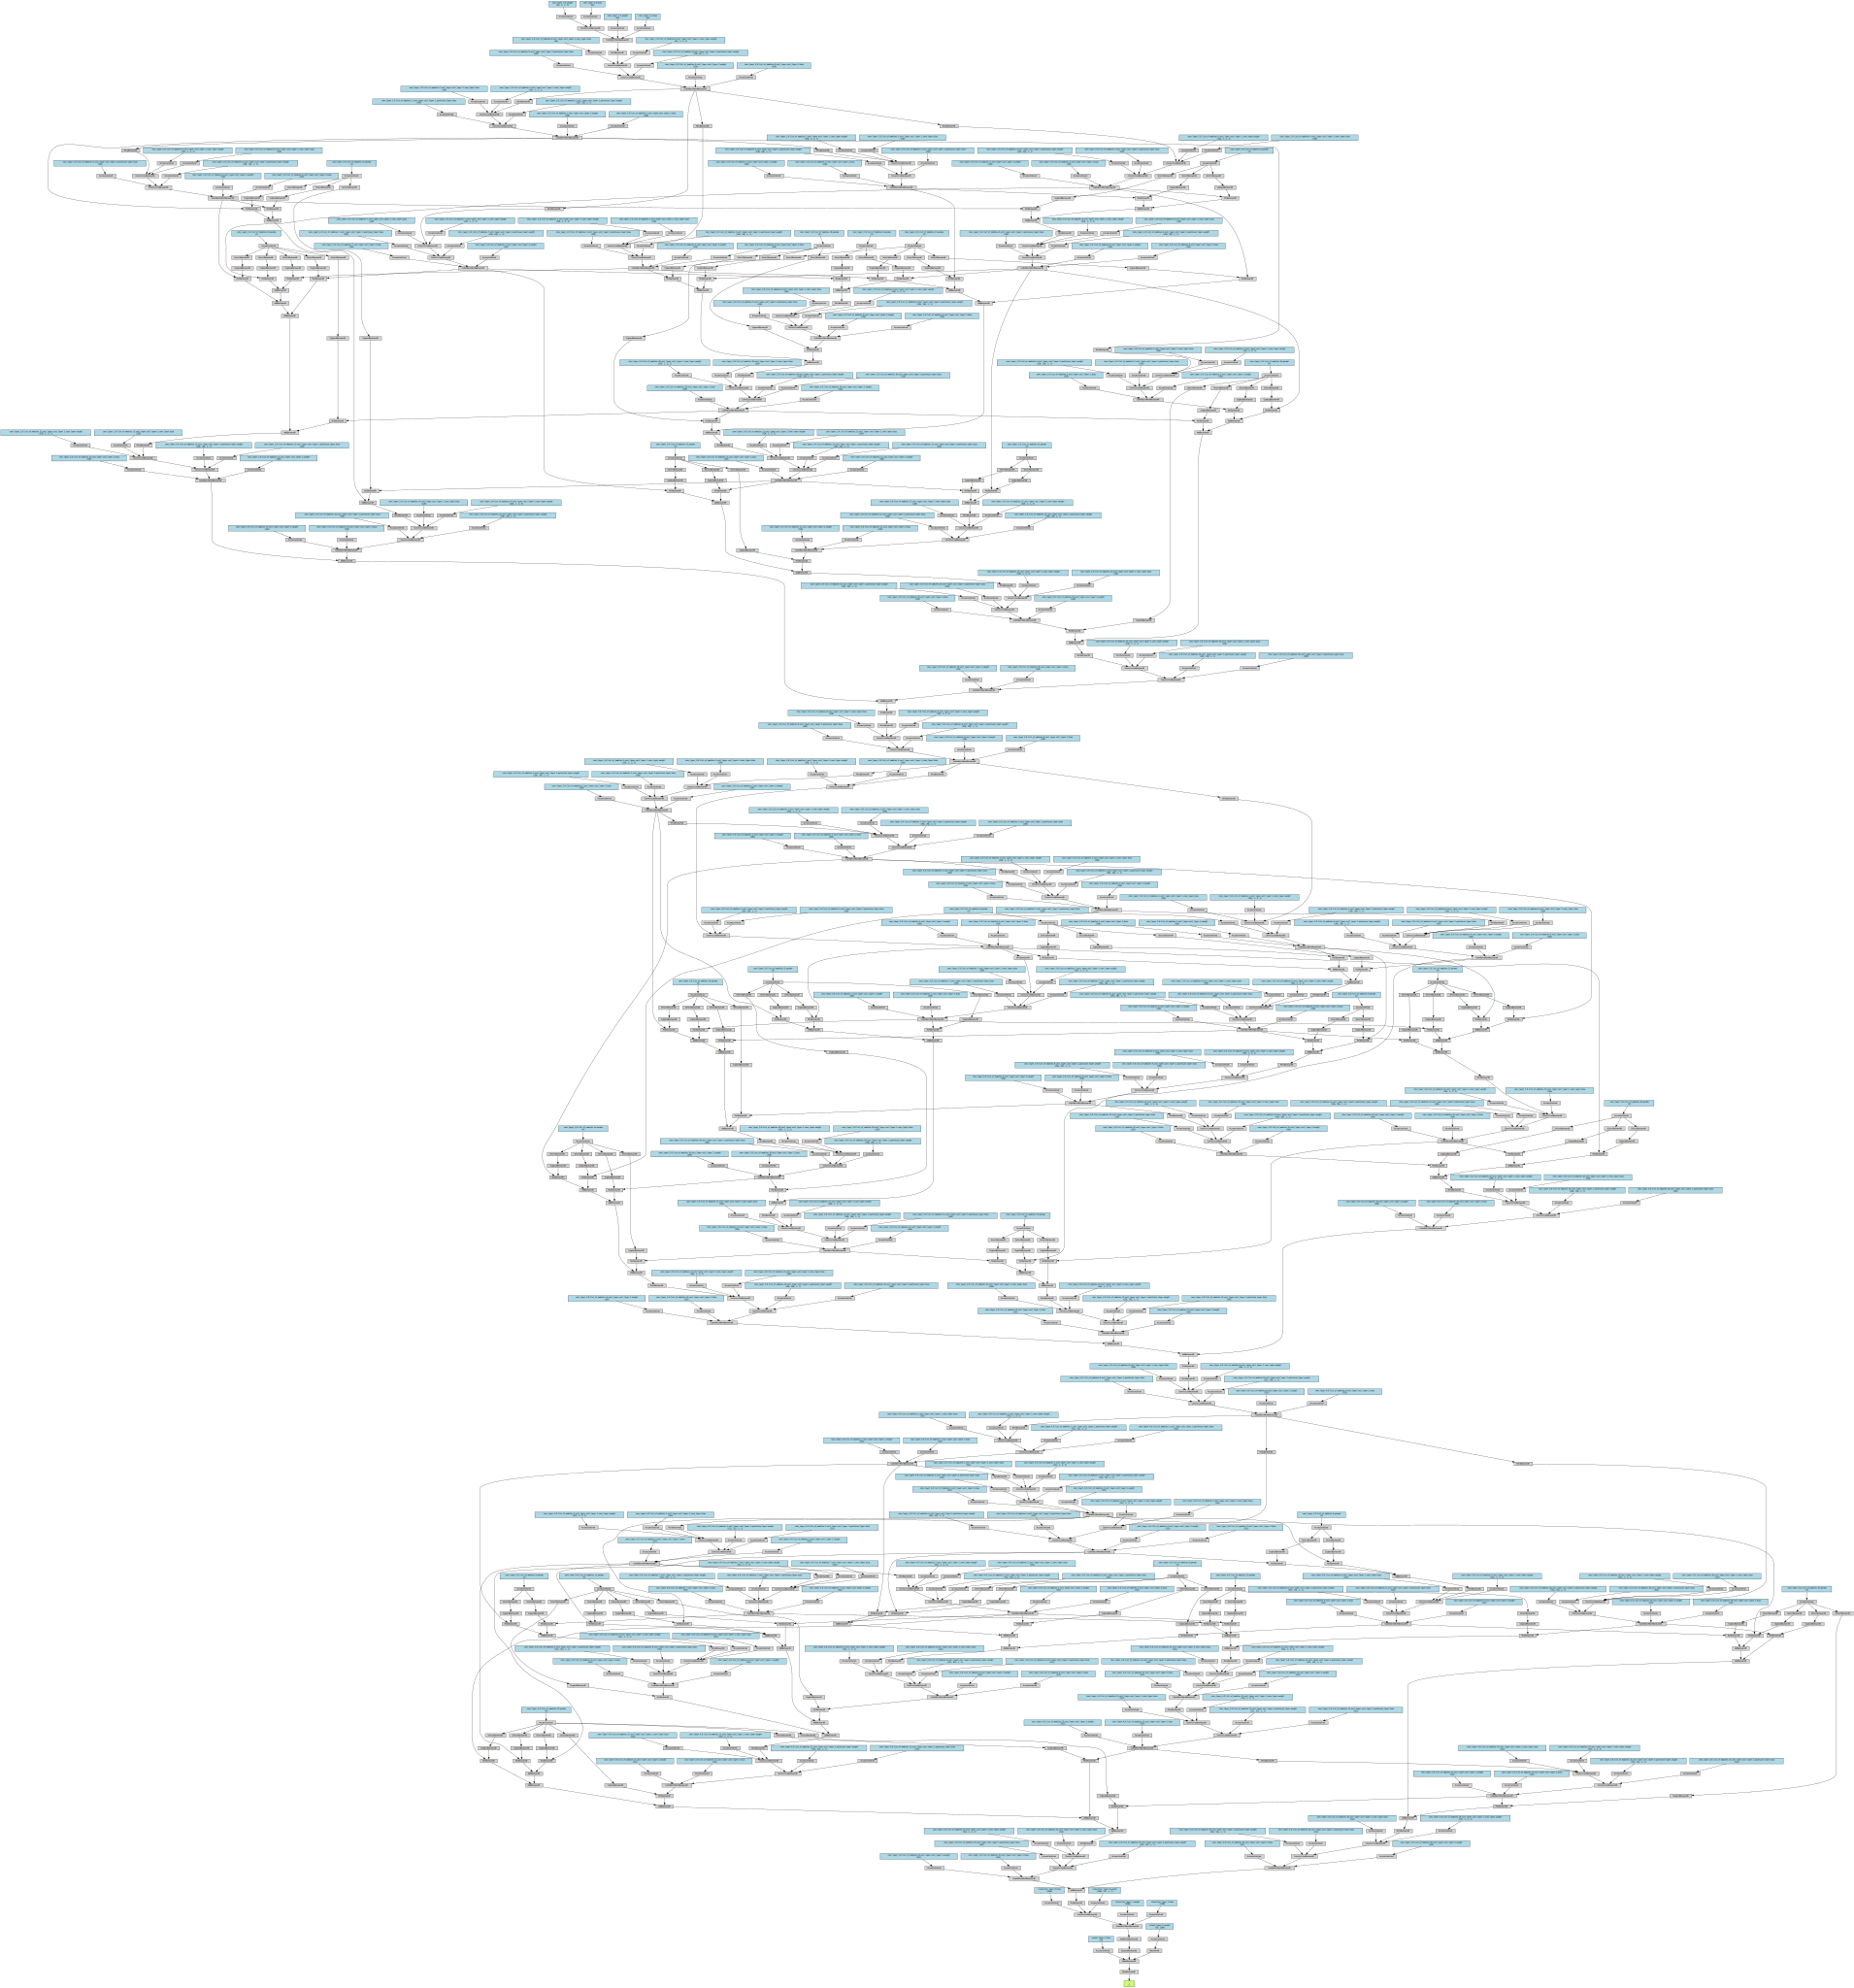

In [29]:
g

- 제일 위에서 이 신경망의 시작 부분을 볼 수 있다. 이 부분은 64채널 3x3 2차원 합성곱 계층, 64채널 1x1 점별 2차원 합성곱 계층을 이어 구성한다.  
- 중간부는 세 번째 단계 랜덤 그래프와 네 번째 단계 랜덤 그래프 사이 바뀌는 부분을 볼 수 있다. 여기서는 3단계 랜덤 그래프인 `conv_layer_3`의 sink 뉴런과 뒤이어 나오는 4단계 랜덤 그래프인 `conv_layer_4`의 source뉴런을 볼 수 있다.  
- 마지막으로 그래프의 가장 아랫 부분에서는 최종 출력 계층, 4단계 랜덤 그래프의 sink 뉴런(512 채널 분리 가능한 2차원 합성곱 계층)을 보여준다. 그 뒤로 완전 연결 평면화 계층이 이어지고 그 결과로 크기가 1,280인 특징 벡터를 얻게 된다. 뒤이어 완전 연결 소프트맥스 계층이 나오고 여기에서 10개 클래스의 확률이 만들어진다.

신경망 아키텍처 검색은 딥러닝 분야에서 지속적으로 연구되는 유망한 영역이다. 대체로 이것은 AutoML이라고 하는 특정 작업에 대한 맞춤형 머신러닝 모델 훈련 분야와 잘 맞는다.  
**AutoML**에서는 데이터셋을 수동으로 로딩하거나, 특정 작업을 해결하기 위해 특정 신경망 모델 아키텍처를 사전에 정의하고 모델을 운영 시스템에 수동으로 배포할 필요가 없기 때문에 **자동화된 머신 러닝(Automated Machine Learning)**을 의미한다.